# Die Bildverarbeitungspipeline (2/2) - Bildvorverarbeitung


![(misc/pipeline.png)](misc/pipeline.png)



## Hough Algorithmus zur Erkennung von Fahrbahnmarkierungen

In der ersten Übung sollen die Algorithmen für die letzten 3 Schritte der Bildverarbeitungspipeline durchgeführt werden. Der Hough Algorithmus erfordert wahlfreien Zugriff auf den Speicher. Deshalb bietet sich in der späteren Umsetzung der ARM Mikrocontroller für diesen Teil der Bildverarbeitungspipeline an.

In diesem Notebook soll der Hough-Algorithmus zum Erkennen von Linien in einem Bild umgesetzt werden. 
* Als Ausgangspunkt können verschiedene Bilder mit Fahrbahnmarkierungen gewählt werden
* Die Vorverarbeitung der Bilder wird dieses mal aus Performance-Gründen mit OpenCV umgesetzt (vorgegeben)
* Zusätzlich kann ein generiertes Bild mit eingezeichneten Linien zum Testen verwendet werden
* Anschließend wird die Hough Transformation umgesetzt
* und eine Linie in das Eingangsbild gezeichnet

Hinweise:
* Die Python-Sprachkonstrukte (Schleifen, Bedingungen, ...) sind hier beschrieben: https://www.learnpython.org/en/Welcome

* Codeabschnitte, die bearbeitet werden müssen, sind mit '### TODO ###' gekennzeichnet.

### Standard-Bibliotheken einbinden
Zuerst werden ein paar nützliche Bibliotheken geladen.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
import cv2
%matplotlib inline



### Folgende Bilder stehen zum Testen zur Auswahl:

In [2]:
import os
os.listdir("test_images/")



['solidWhiteRight.jpg',
 'solidYellowLeft.jpg',
 'solidYellowCurve.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowCurve2.jpg']

### Bild einlesen:

In [3]:
image = mpimg.imread('test_images/solidWhiteRight.jpg')
height = image.shape[0]
width = image.shape[1]


### Bildvorverarbeitung mittels OpenCV

Die Algorithmen der letzten Übung werden hier für eine bessere Performance mit OpenCV umgesetzt. In der späteren Embedded Umsetzung wird dieser Teil von einem selbst entwickelten Hardwarebeschleuniger auf dem FPGA übernommen.

In [4]:
# Graustufen
image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Kantenerkennung mittels Canny Algorithmus
low_threshold = 5
high_threshold = 200
image_canny = cv2.Canny(image_gray, low_threshold, high_threshold)

# 'Region of Interrest' im Bild definieren - Es wird nur der untere Teil des Bildes verwendet
region_points = np.array( [[[0,370],[960,370],[960,540],[0,540]]], dtype=np.int32 )
mask = np.zeros_like(image_canny)
cv2.fillPoly(mask, region_points, 255)
image_region = cv2.bitwise_and(image_canny, mask)



### Testbild generieren

Alternativ kann hier zu Testzwecken ein Bild mit selbst gezeichneten Linien generiert werden.

In [5]:

bildbreite = 100
bildhoehe = 100

test_pattern_rgb = np.zeros((bildbreite, bildhoehe, 3), dtype=np.uint8)

# Horizontale Linien
##cv2.line(test_pattern_rgb, (0, 20), (99, 20), [255, 255, 255], 1)
##cv2.line(test_pattern_rgb, (0, 50), (99, 50), [255, 255, 255], 1)
##cv2.line(test_pattern_rgb, (0, 70), (99, 70), [255, 255, 255], 1)

# Vertikale Linien
##cv2.line(test_pattern_rgb, (40, 0), (40, 99), [255, 255, 255], 1)
##cv2.line(test_pattern_rgb, (60, 0), (60, 99), [255, 255, 255], 1)

# Diagonale Linien
##cv2.line(test_pattern_rgb, (0, 0), (99, 99), [255, 255, 255], 1)
##cv2.line(test_pattern_rgb, (0, 99), (99, 0), [255, 255, 255], 1)
##cv2.line(test_pattern_rgb, (0, 40), (59, 99), [255, 255, 255], 1)
##cv2.line(test_pattern_rgb, (10, 0), (90, 99), [255, 255, 255], 1)
##cv2.line(test_pattern_rgb, (70, 0), (99, 29), [255, 255, 255], 1)
##cv2.line(test_pattern_rgb, (0, 40), (40, 0), [255, 255, 255], 1)


############################
### Fahrbahnlinien
############################

# links, spitzer Winkel
cv2.line(test_pattern_rgb, (round(0.1* bildbreite), bildhoehe-1), (round(0.3*bildbreite), round(bildhoehe*0.6)), [255, 255, 255], 1)
# links, stumpfer Winkel
##cv2.line(test_pattern_rgb, (round(0.1* bildbreite), bildhoehe-1), (round(0.7*bildbreite), round(bildhoehe*0.6)), [255, 255, 255], 1)

# rechts, spitzer Winkel
cv2.line(test_pattern_rgb, (round(0.9* bildbreite), bildhoehe-1), (round(0.7*bildbreite), round(bildhoehe*0.6)), [255, 255, 255], 1)
#rechts, stumpfer Winkel
##cv2.line(test_pattern_rgb, (round(0.9* bildbreite), bildhoehe-1), (round(0.4*bildbreite), round(bildhoehe*0.6)), [255, 255, 255], 1)

# Nur 1 Punkt
##cv2.line(test_pattern_rgb, (20, 50), (20, 50), [255, 255, 255], 1)


# In Graustufen umwandeln
test_pattern = cv2.cvtColor(test_pattern_rgb, cv2.COLOR_RGB2GRAY)






# Testmuster oder Bild auswählen

Bildgröße: X= 960  Y= 540


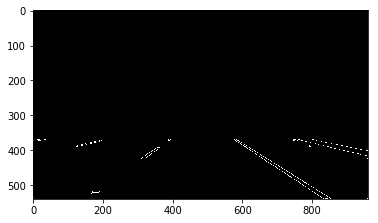

In [41]:
SELECT_TESTPATTERN = 1

if SELECT_TESTPATTERN == 1:
    input_image = test_pattern_rgb
    preprocessed_image = test_pattern

else:
    input_image = image
    preprocessed_image = image_region
    bildbreite = preprocessed_image.shape[1]
    bildhoehe = preprocessed_image.shape[0]


print('Bildgröße: X=', bildbreite, ' Y=', bildhoehe)
plt.figure()
plt.imshow(preprocessed_image, cmap='gray')


## Punktkoordinaten der gefundenen Kanten in einer Liste speichern

Die Punktkoordinaten werden später von der Hardware übergeben. Für den Hough-Entwurf in diesem Notebook wird hier die Liste generiert. Dazu müssen die X- und Y-Koordinaten aller weißen Pixel des vorverarbeiteten Eingabebildes in einer Liste gespeichert werden.

In [42]:

# Maximale Größe der Punkte-Liste
MAX_POINTS = 5000

# Liste anlegen
points = [None] * MAX_POINTS

# Punkte-Zähler zurücksetzen
point_counter=0

### TODO ###: Durchsuche das komplette Bild nach weißen Pixeln und speichere die Koordinaten in einer Liste


# Anzahl gefundener Punkte ausgeben
print('Gefundene Punkte:',point_counter)

Gefundene Punkte: 1809



# Hough Transformation

Ab hier wird der Algorithmus dann später vom ARM Prozessor umgesetzt.

Nähere Informationen zum Linien-Hough findet man unter https://de.wikipedia.org/wiki/Hough-Transformation


### Parameter festlegen

In [44]:
# Maximale Größe der Normalen einer Linie und Bildmittelpunkt

max_abstand = round(math.sqrt( (bildbreite)**2 + (bildhoehe)**2))

min_abstand = max_abstand * -1


# Anzahl der Auflösungsschritte (in einem Halbkreis) zur Richtungsbestimmung einer Linie
winkel_aufloesung = 180

print('Maximale Normalen-Distanz:',max_abstand)
print('Minimale Normalen-Distanz:',min_abstand)
print('Winkelauflösung:',winkel_aufloesung)

Maximale Normalen-Distanz: 1101
Minimale Normalen-Distanz: -1101
Winkelauflösung: 180




### Hough-Raum berechnen

In [45]:
# schwarzes Bild für Hough Raum generieren
houghRaum = np.zeros((max_abstand - min_abstand, winkel_aufloesung), dtype=np.uint8)


### TODO ###: Hough Transformation für jeden Pixel durchführen und in houghRaum speichern


### Maximum im Hough-Raum finden

In [46]:
# Maximum zurücksetzen
hough_max = 0
hough_max_position = [0,0]

### TODO ###




            
hough_distanz = hough_max_position[0]
hough_winkel = hough_max_position[1]
    
# gefundenes Maximum ausgeben
print('Maximale Überschneidungen:',hough_max,'  Winkel(x):',hough_winkel,' Distanz(y):',hough_distanz)



Maximale Überschneidungen: 223   Winkel(x): 122  Distanz(y): 4


### Hough-Raum auf gefundenes Maximum normalisieren

... um die Transformation in den Hough-Raum zu plotten.
Beim generierten Testbild sollte das Ergebnis in etwa so aussehen:
![(misc/example_hough_space.png)](misc/example_hough_space.png)

Maximale Überschneidungen: 223   Winkel(x): 122  Distanz(y): 4


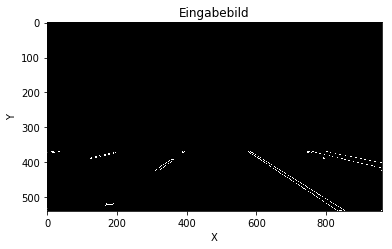

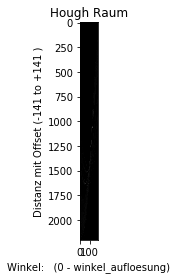

In [47]:


houghRaum_Normalized = np.zeros(( max_abstand - min_abstand , winkel_aufloesung, 3), dtype=np.uint8)


### TODO ###: Normalisierter Hough-Raum


# Original Bild ausgeben
fig = plt.figure()
plt.xlabel('X')
plt.ylabel('Y')
plt.imshow(preprocessed_image, cmap='gray')
plt.title('Eingabebild')

# Hough-Raum ausgeben
fig2 = plt.figure()
plt.xlabel('Winkel:   (0 - winkel_aufloesung)')
plt.ylabel('Distanz mit Offset (-141 to +141 )')
plt.imshow(houghRaum_Normalized, cmap='gray')
plt.title('Hough Raum')

# gefundenes Maximum ausgeben
print('Maximale Überschneidungen:',hough_max,'  Winkel(x):',hough_winkel,' Distanz(y):',hough_distanz)



### Linie zeichnen

Der nachfolgende Block 'Ausgabebild erstellen' wird die Funktion 'hough_linie_zeichnen' aufrufen. Die Funktion erhält Winkel und Distanz vom Maximum im Hough-Raum und soll die Linienkooridinaten (x1,y1,x2,y2) zurückgeben. Die Linie wird anschließend in das Eingangsbild gezeichnet.

In [48]:
def hough_linie_zeichnen(winkel,distanz):

   
    ### TODO ###
  
    
    return [x1,y1,x2,y2]


### Ausgabebild erstellen

Koordinaten der Linienpunkte (x1,y1,x2,y2): [857, 540, 512, 324]


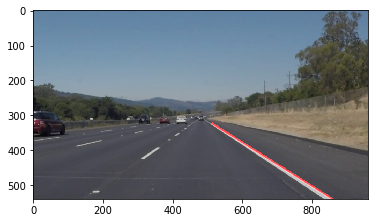

In [49]:

# neues schwarzes Bild generieren
result_image = np.zeros((bildhoehe, bildbreite, 3), dtype=np.uint8)

# Koordinaten für Linie berechnen
punkte_gerade = hough_linie_zeichnen(hough_winkel,hough_distanz)
print('Koordinaten der Linienpunkte (x1,y1,x2,y2):',punkte_gerade)

# Linie zeichnen
cv2.line(result_image, (punkte_gerade[0], punkte_gerade[1]), (punkte_gerade[2], punkte_gerade[3]), [255, 0, 0], 5)



# Hough-Linie mit Eingangsbild überlagern 
bild_ueberlagert = cv2.addWeighted(input_image, 0.8, result_image, 1, 0.)

# Bild ausgeben
fig = plt.figure()
##plt.imshow(result_image)
plt.imshow(bild_ueberlagert)




# Videostream

Nun soll eine Funktion beschrieben werden, die als Eingang die Einzelbilder eines Videostreams bekommt und diese Einzelbilder verarbeitet zurückgibt. Dabei sollen

- die linke und rechte Fahrspur getrennt betrachten
- die Hough-Transformation auf eine sinnvolle Winkelregion und Distanz beschränkt werden
- optional der Algorithmus weiter optimiert werden

In [50]:

def bildverarbeitungskette(image):
    
    bildhoehe = image.shape[0]
    bildbreite = image.shape[1]

    # Graustufen
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Canny Algorithmus
    low_threshold = 5
    high_threshold = 200
    image_canny = cv2.Canny(image_gray, low_threshold, high_threshold)

    # Region of interrest - nur untere Hälfte des Bildes betrachten
    region_points = np.array( [[[0,bildhoehe*0.6],[bildbreite,bildhoehe*0.6],[bildbreite,bildhoehe],[0,bildhoehe]]], dtype=np.int32 )
    mask = np.zeros_like(image_canny)
    cv2.fillPoly(mask, region_points, 255)
    image_region = cv2.bitwise_and(image_canny, mask)
    
    ### TODO ###
    
    
    
    
    # Ausgangsbild muss im RGB Format sein
    backtorgb = cv2.cvtColor(image_region,cv2.COLOR_GRAY2RGB)

    return backtorgb

### Video umwandeln

Es stehen folgende Videos zur Verfügung:

In [51]:
import os
os.listdir("test_videos/")

['challenge.mp4', 'solidWhiteRight.mp4', 'solidYellowLeft.mp4']

##### Die Videokonvertierung muss noch mit der Variable 'enable_video' aktiviert werden

In [52]:
# notwendige Bibliotheken zur Videoverarbeitung laden
import moviepy.editor as mpy
from moviepy.editor import VideoFileClip
from IPython.display import HTML


enable_video=1

if not SELECT_TESTPATTERN == 1 and enable_video==1:

    # Ausgabe-Video
    # Codec Optionen: https://zulko.github.io/moviepy/_modules/moviepy/video/VideoClip.html
    ##video_ausgabe = 'test_videos_output/solidWhiteRight.mp4'
    video_ausgabe = 'test_videos_output/solidWhiteRight.webm'

    # Eingabe-Video
    clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
    
    # nur einen Teil des Eingabe-Videos verwenden, um die Berechnung zu beschleunigen
    ##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,0.5)


    # Bild in Ausgabevideo speichern
    write_clip = clip1.fl_image(bildverarbeitungskette)
    %time write_clip.write_videofile(video_ausgabe, audio=False, fps=30)
    


NeedDownloadError: Need ffmpeg exe. You can download it by calling:
  imageio.plugins.ffmpeg.download()

### Video abspielen

In [ ]:
# Video einbetten - funktioniert auf den Laborrechnern nur bei .webm
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_ausgabe))

# Eingangsvideo
##import pygame
##clip1.preview(audio=False)
##pygame.quit()